# Problem 1: Regression in big-n
**Updated:** 2019-06-10   
**Author:** Anna Carlsson

### Packages

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LassoLars, LassoLarsCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from glmnet_python.cvglmnet import cvglmnet
from glmnet_python.glmnet import glmnet
from glmnet_python.cvglmnetCoef import cvglmnetCoef
from glmnet_python.glmnetPlot import glmnetPlot

%matplotlib inline
plt.style.use('ggplot')

### Load data and split into train/test

In [2]:
os.chdir("/Users/anna/Dokument/GitHub/MVE440/Exam/Datasets/")

data = np.load("exercise1.npz")
features = data['XA1']
labels = data['yA1']

#features = data['XA2']
#labels = data['yA2']

#features = data['XB1']
#labels = data['yB1']

#features = data['XB2']
#labels = data['yB2']

data.close()

(100, 10)


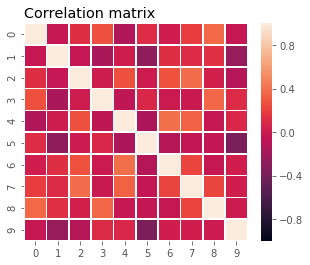

In [3]:
# Examine data
print(np.shape(features))

# Look for correlated features
corr = np.corrcoef(features.T)
plt.figure(figsize=(5, 4))
sns.heatmap(corr,vmin=-1, vmax=1,linewidth=0.5)
plt.title('Correlation matrix',loc='left')
plt.savefig('corr_matrix.pdf') 

# Split into train/test set
train_features, test_features, train_labels, test_labels = train_test_split(  
    features,
    labels,
    test_size=0.2)

p = np.shape(features)[1]
N = np.shape(features)[0]

## Filtering methods

### Select features based on correlation with target
In this part, I rank the features in the dataset based on their correlation with the labels. Then, I add them one-by-one and compute the MSE.

2.9527994087932816


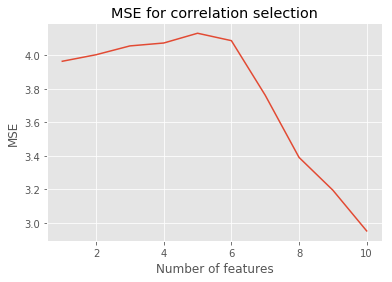

In [4]:
c = np.corrcoef(features.T, labels)[:-1,-1] # order corresponding to the order of the features
c = np.abs(c)
rank = np.argsort(c)

corr_mse = np.arange(p, dtype=float)

for n in range(p):
    num_features = n + 1
    features_temp = rank[0:num_features]
    model = LinearRegression()
    scores_temp = cross_val_score(model, features[:,features_temp], labels, cv=10, 
                                 scoring='neg_mean_squared_error')
    corr_mse[n] = np.mean(scores_temp)
    
corr_mse *= -1;
print(np.min(corr_mse))

plt.plot(range(1,p+1),corr_mse);
plt.title('MSE for correlation selection');
plt.ylabel('MSE');
plt.xlabel('Number of features');

2.9527994087932816
9


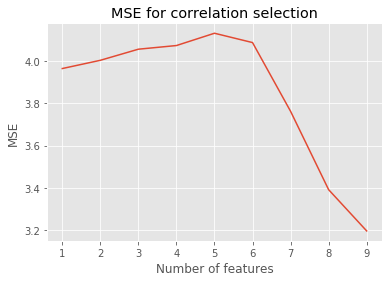

In [11]:
# Create zoomed in plot
plt.plot(range(1,10),corr_mse[0:9]);
plt.title('MSE for correlation selection');
plt.ylabel('MSE');
plt.xlabel('Number of features');
#print(np.min(rf_mse))

print(np.min(corr_mse))
print(np.argmin(corr_mse))

### Random forest

In [12]:
rf = RandomForestRegressor(n_estimators=300) 
rf.fit(train_features, train_labels) 
importances = rf.feature_importances_
feature_importances = np.argsort(importances)[::-1]

rf_mse = np.arange(p, dtype=float)

for n in range(p):
    num_features = n + 1
    features_temp = feature_importances[0:num_features]
    model = LinearRegression()
    scores_temp = cross_val_score(model, features[:,features_temp], labels, cv=10, 
                                 scoring='neg_mean_squared_error')
    rf_mse[n] = np.mean(scores_temp)

rf_mse *= -1;
print(np.min(rf_mse))
print(np.argmin(rf_mse))


2.8376079804827854
5


[6 7 2 4 3 9 5 1 8 0]


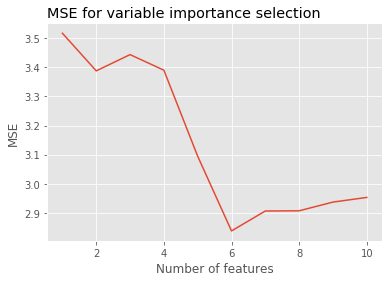

In [13]:
plt.plot(range(1,p+1),rf_mse);
plt.title('MSE for variable importance selection',loc='left');
plt.ylabel('MSE');
plt.xlabel('Number of features');
plt.savefig('random_forest_full.pdf')
print(feature_importances)

In [ ]:
# Create zoomed in plot
plt.plot(range(1,31),rf_mse[0:30]);
plt.title('MSE for variable importance selection',loc='left');
plt.ylabel('MSE');
plt.xlabel('Number of features');
print(np.min(rf_mse))
print(np.argmin(rf_mse))
plt.savefig('random_forest.pdf')

## Wrapping methods

### Forward selection

2.8376079804827845
5


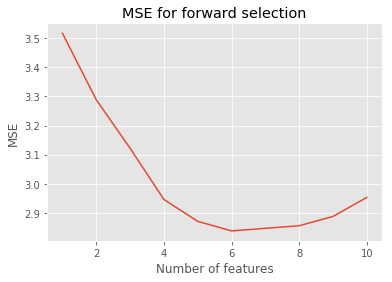

In [14]:
fs = SFS(LinearRegression(),  
         k_features=p,
         forward=True,
         verbose=0,
         scoring='neg_mean_squared_error',
         cv=10)

sel_features = fs.fit(features, labels) 
filtered_features = list(sel_features.k_feature_idx_)


# Save MSE scores to array
metric = fs.get_metric_dict()
orderedNames = list(metric.keys())
forward_mse = np.array([list(metric[i]['avg_score'] for i in orderedNames)])
forward_mse = forward_mse.T
forward_mse *= -1

print(np.min(forward_mse))
print(np.argmin(forward_mse))

plt.plot(range(1,p+1),forward_mse);
plt.title('MSE for forward selection');
plt.ylabel('MSE');
plt.xlabel('Number of features');

In [17]:
# Extract the best features
fs = SFS(LinearRegression(),  
         k_features=6,
         forward=False,
         verbose=0,
         scoring='neg_mean_squared_error',
         cv=10)

sel_features = fs.fit(features, labels) 
filtered_features = list(sel_features.k_feature_idx_)
print(filtered_features)

[2, 3, 4, 6, 7, 9]


### Backward selection

2.8376079804827845
5


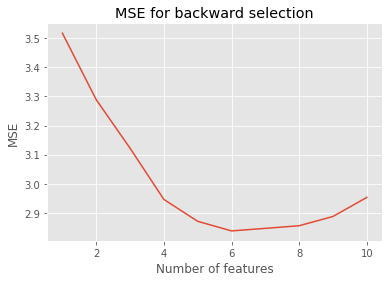

In [18]:
bs = SFS(LinearRegression(),  
         k_features=1,
         forward=False,
         verbose=0,
         scoring='neg_mean_squared_error',
         cv=10)

sel_features = bs.fit(features, labels) 
filtered_features = features[:,list(sel_features.k_feature_idx_)]

# Save MSE scores to array
metric = bs.get_metric_dict()
orderedNames = list(metric.keys())
backward_mse = np.array([list(metric[i]['avg_score'] for i in orderedNames)])
backward_mse = np.flip(backward_mse).T
backward_mse *= -1

print(np.min(backward_mse))
print(np.argmin(backward_mse))

plt.plot(range(1,p+1),backward_mse);
plt.title('MSE for backward selection');
plt.ylabel('MSE');
plt.xlabel('Number of features');

### Exhaustive search
This section will only be run for the smaller datasets. For some reason, MSE cannot be selected but instead only negative MSE which equals -1*MSE.

In [ ]:
fs = EFS(LinearRegression(),  
         min_features=1,
         max_features=p,
         print_progress=False,
         scoring='neg_mean_squared_error',
         cv=10)

sel_features = fs.fit(features, labels) 

print('Best accuracy score: %.2f' % fs.best_score_)
print('Best subset (indices):', fs.best_idx_)
print('Best subset (corresponding names):', fs.best_feature_names_)

## Embedded methods


### Lasso
First, use the ``cvglmnet`` function to find the optimal value of $\lambda$ via 10-fold CV, then plot the regularization path to find the set of variables to keep.

In [19]:
folds = 10
cvfit = cvglmnet(x = features, y = labels, alpha=1, ptype = 'mse', nfolds = folds, parallel=True, standardize=True)

lambda_max = cvfit['lambda_1se']
lambda_opt = cvfit['lambda_min']

n_lambdas = 50
lambdas = np.logspace(-10, 1, n_lambdas)

scaler = StandardScaler()
scaler.fit(features)
features_std = scaler.transform(features)


coefs = []
for l in lambdas:
    lasso = Lasso(alpha=l, normalize = False, tol=1e-3) # tol 0.09 for B1, 0.4 for B2
    lasso.fit(features_std, labels)
    coefs.append(lasso.coef_)

[0.27621327]
[0.03250511]


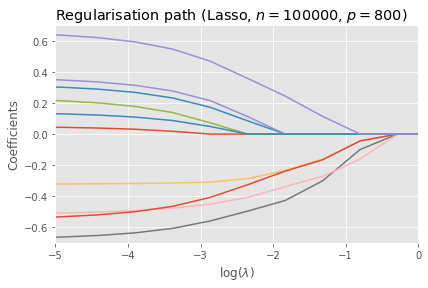

-3.349426929349702
(array([3, 4, 6, 7, 9]),)


In [21]:
print(lambda_max)
print(lambda_opt)

plt.figure(figsize=(6.5,4))
plt.plot(np.log(lambdas),coefs)
plt.axis([-5,0,-0.7,0.7])
#plt.axvline(np.log(lambda_max))
#plt.axvline(np.log(0.23),linestyle='--')
plt.title(r'Regularisation path (Lasso, $n=100000$, $p=800$)',loc='left');
plt.xlabel(r'log($\lambda$)');
plt.ylabel('Coefficients');
plt.savefig('reg_path_lasso.pdf')
plt.show()

model = Lasso(alpha=lambda_max,normalize = False,tol=1e-3) #0.09 B1
model.fit(features_std, labels)
scores_temp = cross_val_score(model, features_std, labels, cv=10, scoring='neg_mean_squared_error')
l_mse = np.mean(scores_temp)
print(l_mse)

coeffs = pd.Series(model.coef_, index=range(p))
print(coeffs.to_numpy().nonzero())

### Elastic net


In [22]:
folds = 10
cvfit = cvglmnet(x = features, y = labels, alpha=0.5, ptype = 'mse', nfolds = folds, parallel=True,standardize=True)

lambda_max = cvfit['lambda_1se']

n_lambdas = 500
lambdas = np.logspace(-10, 1, n_lambdas)

coefs = []
for l in lambdas:
    el_net = ElasticNet(alpha=l, l1_ratio =0.6, normalize = False,tol=0.09) 
    el_net.fit(features_std, labels)
    coefs.append(el_net.coef_)

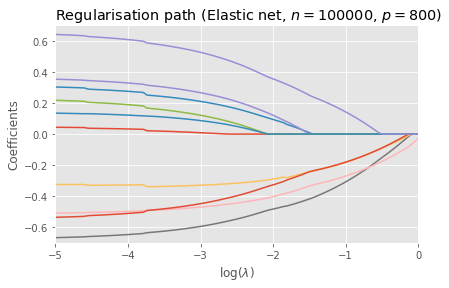

-3.5204428501287133
(array([3, 4, 6, 7, 9]),)


In [23]:
plt.figure(figsize=(6.5,4))
plt.plot(np.log(lambdas),coefs)
plt.axis([-5,0,-0.7,0.7])
#plt.axvline(np.log(lambda_max))
#plt.axvline(np.log(0.42),linestyle='--')
plt.title(r'Regularisation path (Elastic net, $n=100000$, $p=800$)',loc='left');
plt.xlabel(r'log($\lambda$)');
plt.ylabel('Coefficients');
plt.savefig('reg_path_elnet.pdf')
plt.show()

model = ElasticNet(alpha=lambda_max, l1_ratio=0.6, normalize = False)
model.fit(features_std,labels)
scores_temp = cross_val_score(model, features_std, labels, cv=10, scoring='neg_mean_squared_error')
en_mse = np.mean(scores_temp)
print(en_mse)

coeffs = pd.Series(model.coef_, index=range(p))
print(coeffs.to_numpy().nonzero())

## Others

### Relative importance
Since the ``relaimpo`` package only exists in R, the relative importance is computed in R and then exported so that all results are collected here.

[3 6 7 4 9 2 1 5 8 0]
2.8376079804827845
5


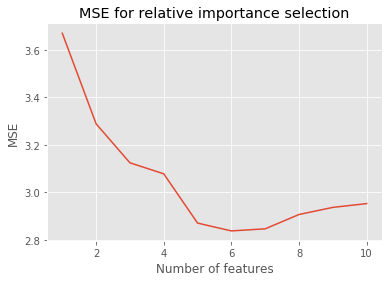

In [24]:
#A1
relimp = np.array([0.005360544,0.027122487,0.028665306,0.246889531,0.146056651,0.011525049,0.216994106,0.164310407,0.011113038,0.141962881])
#A2
#relimp = np.array([0.0010476316,0.0092856146,0.0323708694,0.1550835145,0.1086284549,0.0099529687, 0.1707739907,0.3547646415,0.0009179414, 0.1571743727])
#B1
#relimp = pd.read_csv('1relimp_b1.csv')

relimp_sorted = np.argsort(relimp)[::-1]
print(relimp_sorted)
relimp_mse = np.arange(p, dtype=float)

for n in range(p):
    num_features = n + 1
    features_temp = relimp_sorted[0:num_features]
    model = LinearRegression()
    scores_temp = cross_val_score(model, features[:,features_temp], 
                                  labels, 
                                  cv=10, 
                                  scoring='neg_mean_squared_error')
    relimp_mse[n] = np.mean(scores_temp)
    
relimp_mse *= -1
print(np.min(relimp_mse))
print(np.argmin(relimp_mse))
    
plt.plot(range(1,p+1),relimp_mse);
plt.title('MSE for relative importance selection');
plt.ylabel('MSE');
plt.xlabel('Number of features');

## Plots

### Plots of MSE for all methods applicable 

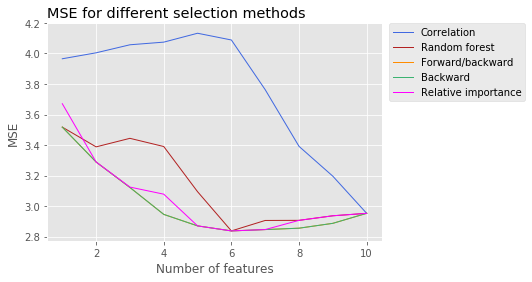

In [25]:
lw = 1

plt.figure(figsize=(6,4))
plt.plot(range(1,p+1),corr_mse, label='Correlation', color='royalblue', linewidth=lw)
plt.plot(range(1,p+1),rf_mse, label='Random forest', color='firebrick', linewidth=lw)
plt.plot(range(1,p+1),forward_mse,label='Forward/backward', color='darkorange', linewidth=lw)
plt.plot(range(1,p+1),backward_mse,label='Backward', color='mediumseagreen', linewidth=lw)
plt.plot(range(1,p+1),relimp_mse,label='Relative importance', color='fuchsia',linewidth=lw)
plt.title('MSE for different selection methods',loc='left')
plt.xlabel('Number of features')
plt.ylabel('MSE')
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.savefig('A1.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight') 
plt.show()